In [120]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

In [121]:
assembly_data = pd.read_csv('Data/quast/ecoli/transposed_report_200m.tsv', sep='\t')

In [122]:
assembly_data['k'] = assembly_data['Assembly'].apply(lambda x: x.split('_')[0][1:]).astype(int)

In [123]:
assembly_data['coverage'] = assembly_data['Assembly'].apply(lambda x: x.split('_')[2][:len(x.split('_')[2])-1]).astype(int)

In [124]:
assembly_data['fragment_length'] = assembly_data['Assembly'].apply(lambda x: 600 if '600m' in x else 200)

In [125]:
reads = assembly_data['Assembly'].apply(lambda x: x.strip('-contigs'))

In [126]:
assembly_data.index = pd.DataFrame(index=reads).index

In [127]:
ntcard_data = pd.read_csv('Data/ntcard/ntcard_summary_200m.tsv', sep='\t', index_col=0)

# Fit model

In [128]:
import genome_model
from importlib import reload
reload(genome_model)
get_model = genome_model.get_model
simple_model = genome_model.simple_model


In [129]:
xdata = np.arange(1, 301, 1)

In [130]:
model_fit_records = ntcard_data.loc[:, 'f1':'f300'].apply(lambda row: get_model(xdata, row.values, model_type='simple', error_dist=True), axis=1)

In [131]:
model_fit_data = pd.DataFrame.from_records(model_fit_records.values.tolist(),
                                          columns=['N1', 'mu', 'sigma'],
                                          index=model_fit_records.index)

In [132]:
model_fit_data = model_fit_data.join(ntcard_data)
model_fit_data = model_fit_data.join(assembly_data)

# Get repeat/error content

In [133]:
def get_error(row, a, mu, sigma):
    mu_ceil = np.round(mu).astype(int)
    ntcard = row[:mu_ceil+1] # From f1 to mu_ceil
    total_kmers = np.sum(row)
    error = 0
    for x, val in enumerate(ntcard):
        model_val = simple_model(x, a, mu, sigma)
        if val > model_val:
            error += val - model_val
    return error/total_kmers

In [134]:
def get_repeat(row, a, mu, sigma):
    mu_ceil = np.round(mu).astype(int)
    ntcard = row[mu_ceil: ] # From mu_ceil to f400
    total_kmers = np.sum(row)
    repeat = 0
    for x, val in enumerate(ntcard):
        # print(x+mu_ceil, val)
        model_val = simple_model(x+mu_ceil, a, mu, sigma)
        if val > model_val:
            repeat += val - model_val
    return repeat/total_kmers

In [135]:
model_fit_data['ceil_mu'] = np.ceil(model_fit_data['mu']).astype(int)

In [136]:
model_fit_data['error_content'] = model_fit_data.apply(lambda row: get_error(row['f1':'f300'].values, row['N1'], row['mu'], row['sigma']), axis=1)

In [137]:
model_fit_data['repeat_content'] = model_fit_data.apply(lambda row: get_repeat(row['f1':'f300'].values, row['N1'], row['mu'], row['sigma']), axis=1)

In [138]:
model_fit_data['Sample Num'] = model_fit_data.index.map(lambda x: int(x.split('_')[len(x.strip('-contigs').split('_'))-1]))

In [139]:
model_fit_data.to_csv('model_fit_data.tsv', sep='\t')

# Visualize

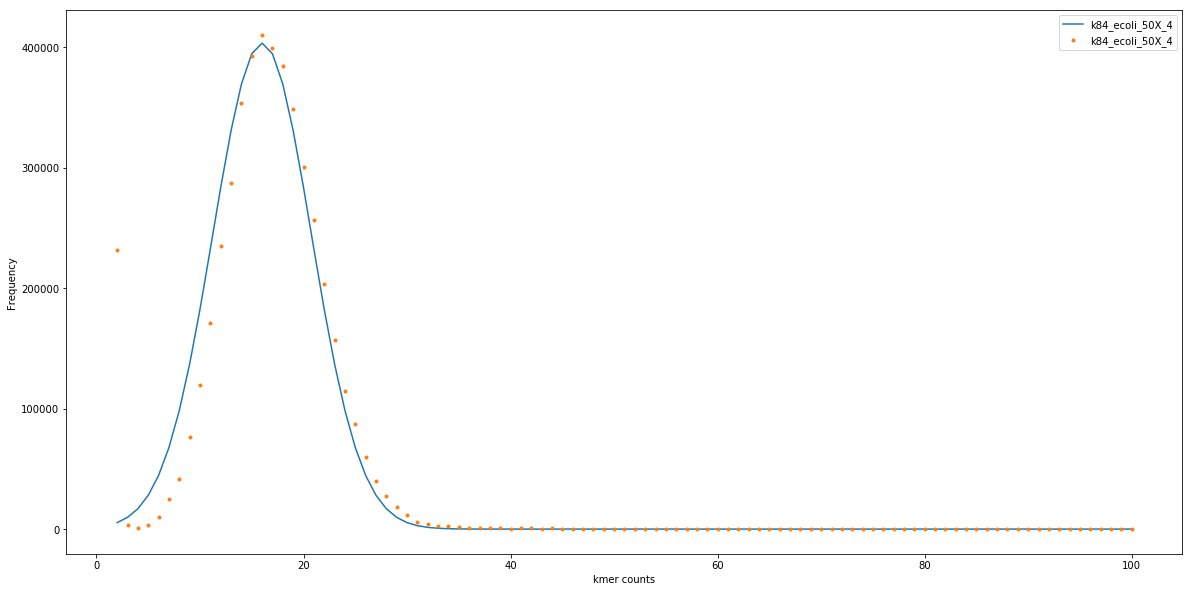

In [140]:
plot_data = model_fit_data[(model_fit_data['Sample Num'] == 4) & (model_fit_data['coverage'] == 50)]

ydatas = plot_data
xdata = np.arange(1, 301, dtype=int)
best_vals = plot_data.loc[:, ['N1', 'mu', 'sigma']]
plt.figure(figsize=(20,10))

for (idx1, ydata), (idx2, best_val) in zip(ydatas.iterrows(), best_vals.iterrows()):
    if ydata['k'] != 84:
        continue
    plt.plot(xdata[1:100], simple_model(xdata, *best_val)[1:100], '-', label='{}'.format(idx1))
    plt.plot(xdata[1:100], ydata['f1': 'f300'][1:100], '.', label='{}'.format(idx1))#, label='empirical')
plt.legend()
plt.xlabel('kmer counts')
plt.ylabel('Frequency')
plt.show()

In [117]:
argrelextrema(ntcard_data.loc['k84_ecoli_20X_1', 'f1':'f300'].values, np.less_equal)

(array([  1,  18,  21,  23,  25,  27,  29,  30,  33,  35,  38,  42,  44,
         46,  49,  52,  55,  58,  62,  65,  67,  69,  71,  74,  75,  76,
         78,  79,  81,  85,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234

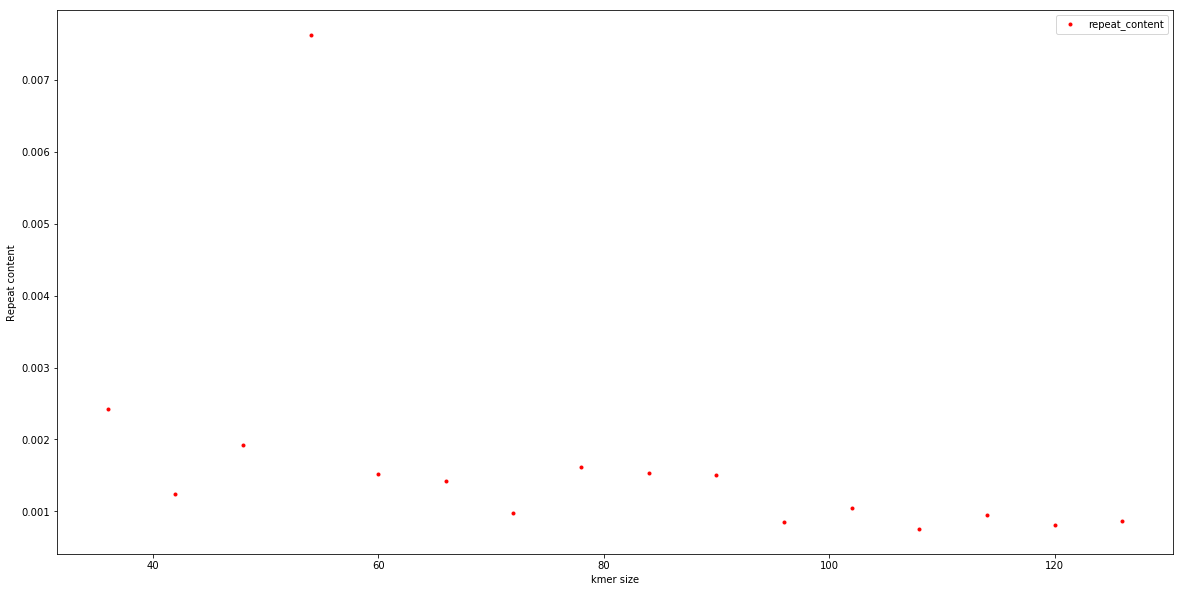

In [118]:
ydata = plot_data['repeat_content']
xdata = plot_data['k']
plt.figure(figsize=(20,10))
plt.plot(xdata, ydata, 'r.')
plt.legend()
plt.xlabel('kmer size')
plt.ylabel('Repeat content')
plt.show()
# plt.savefig('Repeat content.png')

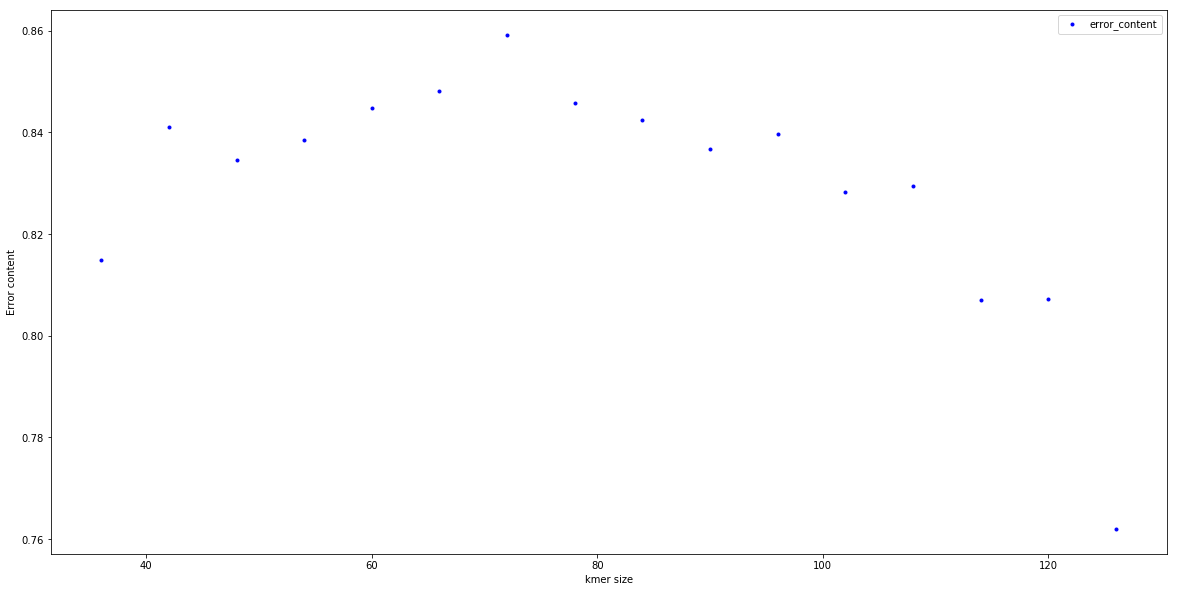

In [119]:
ydata = plot_data['error_content']
xdata = plot_data['k']
plt.figure(figsize=(20,10))
plt.plot(xdata, ydata, 'b.')
plt.legend()
plt.xlabel('kmer size')
plt.ylabel('Error content')
plt.show()
# plt.savefig('Repeat content.png')